In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Updated Label3.xlsx')

In [ ]:
df['Label'] = df['Label'].replace({ True:1,  False:0})

In [ ]:
df2=df.dropna()

In [ ]:
!pip install keras
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(df2, test_size=0.2)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving glove.6B.100d.txt to glove.6B.100d.txt


In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Lemma'])


In [ ]:
num_words = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 200
train_sequences = tokenizer.texts_to_sequences(train_df['Lemma'])
test_sequences = tokenizer.texts_to_sequences(test_df['Lemma'])
train_sequences = pad_sequences(train_sequences, maxlen=max_len)
test_sequences = pad_sequences(test_sequences, maxlen=max_len)


In [ ]:
from keras.layers import Input
from keras.layers import Embedding
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, 
                            output_dim=128, input_length=max_len)(input_layer)
conv_layer_1 = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer_1 = GlobalMaxPooling1D()(conv_layer_1)
dropout_layer_1 = Dropout(0.5)(pooling_layer_1)
dense_layer_1 = Dense(units=32, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.5)(dense_layer_1)
output_layer = Dense(units=1, activation='sigmoid')(dropout_layer_2)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_sequences, train_df['Label'], epochs=10, batch_size=32, validation_data=(test_sequences, test_df['Label']))

Epoch 1/10
2739/2739 [==============================] - 742s 270ms/step - loss: 0.6405 - accuracy: 0.5778 - val_loss: 0.6078 - val_accuracy: 0.5889
Epoch 2/10
2739/2739 [==============================] - 746s 272ms/step - loss: 0.5994 - accuracy: 0.5987 - val_loss: 0.5992 - val_accuracy: 0.5819
Epoch 3/10
2739/2739 [==============================] - 752s 275ms/step - loss: 0.5818 - accuracy: 0.6103 - val_loss: 0.5960 - val_accuracy: 0.5809
Epoch 4/10
2739/2739 [==============================] - 751s 274ms/step - loss: 0.5694 - accuracy: 0.6194 - val_loss: 0.6024 - val_accuracy: 0.5863
Epoch 5/10
2739/2739 [==============================] - 751s 274ms/step - loss: 0.5584 - accuracy: 0.6282 - val_loss: 0.6164 - val_accuracy: 0.5771
Epoch 6/10
2739/2739 [==============================] - 753s 275ms/step - loss: 0.5499 - accuracy: 0.6335 - val_loss: 0.6268 - val_accuracy: 0.5597
Epoch 7/10
2739/2739 [==============================] - 754s 275ms/step - loss: 0.5435 - accuracy: 0.6387 - val_

In [ ]:
from sklearn.metrics import classification_report

# make predictions on the test data
y_pred = model.predict(test_sequences)
y_pred_classes = np.round(y_pred)

# generate classification report
print(classification_report(test_df['Label'], y_pred_classes))


685/685 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

           0       0.51      0.36      0.42     10280
           1       0.55      0.69      0.61     11628

    accuracy                           0.54     21908
   macro avg       0.53      0.53      0.52     21908
weighted avg       0.53      0.54      0.53     21908



685/685 [==============================] - 6s 9ms/step


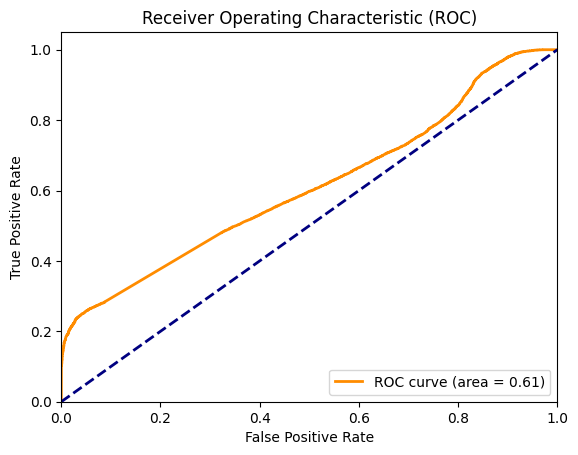

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


probas = model.predict(test_sequences)


fpr, tpr, thresholds = roc_curve(test_df['Label'], probas)


roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

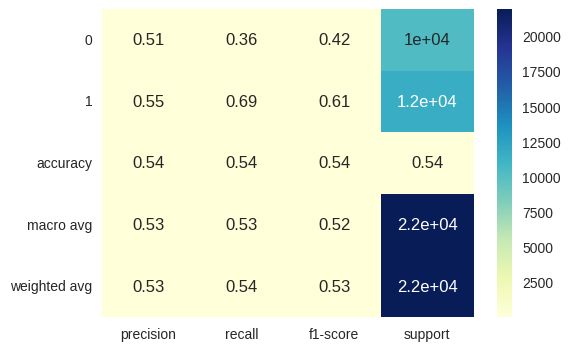

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_report(test_df['Label'], y_pred_classes, output_dict=True)).T, annot=True, cmap='YlGnBu')
plt.show()